Start by copying this into your Google Drive!!

# Information Retrieval & Text Mining 2023 - Topic Modeling Tutorial
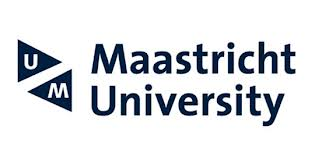
## Tutorial 2 - Notebook 4

Welcome to the tutorial on Topic Modeling. In this notebook we will explore multiple Topic Modeling techniques and will try to improve their results. Topic Modeling is an unsupervised method that can automatically find dominant topics in a corpus. It can help us quickly gain insights into the content of our corpus and make sense of unlabeled data.

We start by installing the requirements. Restart the colab after the installation and go to the next cell (you don't need to run this cell again).

In [ ]:
!pip install bertopic==0.14.1
!pip install -U pyldavis==3.4.1
!pip install numpy==1.23.5

### LSA

LSA can be used for topic modeling by first creating a document-term matrix, applying SVD to extract the underlying semantic relationships between documents and words, reducing the dimensions of the matrix to focus on the most important relationships, and extracting topics by grouping together similar word usage patterns across documents. LSA can then assign words to topics based on their co-occurrence patterns in the documents. This can help identify the most relevant topics within a corpus of documents.

We start by downloading the dataset we will be using for Topic Modeling.

In [ ]:
!wget https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Latent+Semantic+Analysis+in+Python/articles+4.txt

Load the articles as a list.

In [ ]:
import codecs

with codecs.open('./articles+4.txt', 'r', "utf-8") as a:
  docs = [doc.strip() for doc in a.readlines()]

print(len(docs))

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from gensim import corpora
from gensim.models import LsiModel

from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel

nltk.download('stopwords')
nltk.download('punkt')

We define the funtion for preprocessing and tokenizing the text. To make the list of representative words of our topics more interpretable, we remove stop words, which are usually very frequent and less useful for finding the topics. We also use stemming to remove semantic duplicates.

### Exercice 1: 
Replace Stemming with Lemmatization and see whether you perceive a difference in the representative words of each topic.

In [ ]:
def preprocess_data(doc_set):
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))
    p_stemmer = PorterStemmer()
    texts = []

    for i in doc_set:
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in en_stop]
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        texts.append(stemmed_tokens)
    return texts

We prepare our corpus by building the dictionary (a mapping between words of the corpus and their IDs), and build the document-term matrix that will be used by the topic modeling algorithms to find topics.

In [ ]:
def prepare_corpus(clean_docs):
    dictionary = corpora.Dictionary(clean_docs)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_docs]
    return dictionary,doc_term_matrix

In [ ]:
number_of_topics=7                        

clean_docs=preprocess_data(docs)

dictionary,doc_term_matrix=prepare_corpus(clean_docs)

lsa_topic_model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)

In [ ]:
for topic_num, words in lsa_topic_model.show_topics():
    print('Representative words of topic {}: {}.'.format(topic_num, words))

The `CoherenceModel` measures the quality of the topics by measuring the semantic similarity between the top representative words of each topic. A good topic model will produce topics with high semantic semilarity. There are several methods to compute coherence, `coherence` parameter below is used to control which one we are using. In this case, we use `c_uci` which computes the *Pointwise Mutual Information (PMI)* of the top words of each topic. A coherent topic model will have a high coherence score.

In [ ]:
coherencemodel = CoherenceModel(model=lsa_topic_model, texts=clean_docs, dictionary=dictionary, coherence='c_npmi')
coherencemodel.get_coherence()

### Exercice 2:
Find the number of topics that maximizes the coherence score and use it to improve the topic model.

In [ ]:
# WRITE YOUR CODE HERE

### LDA

LDA is a model used for discovering the topics present in a corpus of text documents. It assumes that each document is a mixture of various topics, and each topic is a distribution over the words in the vocabulary. LDA iteratively assigns topics to each word in each document based on the probabilities of the topics being the correct ones, and then updates the topic assignments until convergence. Finally, LDA outputs the topic distribution for each document and the word distribution for each topic.

In [ ]:
from gensim.models import ldamodel
import pyLDAvis
from pyLDAvis import gensim_models

### Exercice 3:
Other than the number of topics, find other hyperparameters of the LDA models and update them to maximize the coherence score computed below.

In [ ]:
lda_topic_model = ldamodel.LdaModel(
    corpus=doc_term_matrix,  
    id2word=dictionary, 
    num_topics=7,    
    random_state=100,
    passes=20,      
    )

In [ ]:
for topic_num, words in lda_topic_model.show_topics():
    print('Representative words of topic {}: {}.'.format(topic_num, words))

In [ ]:
coherencemodel = CoherenceModel(model=lda_topic_model, texts=clean_docs, dictionary=dictionary, coherence='c_uci')
coherencemodel.get_coherence()

pyLDAvis visualizes the topics and makes it easy to interpret the output of the LDA topic model.

In [ ]:
pyLDAvis.enable_notebook()
visualization = gensim_models.prepare(
    lda_topic_model, 
    doc_term_matrix,
    dictionary, 
    mds = "mmds", 
    R = 30)

visualization

### NMF

Non-negative matrix factorization (NMF) is a statistical technique that can be used for topic modeling. It works by factorizing the document-term matrix into two non-negative matrices. document-topic matrix that captures the distribution of topics across the documents, and a topic-term matrix that captures the significance of the terms across the topics. This factorization is performed iteratively, updating the two matrices until the approximation error is minimized. The resulting matrix of topic vectors can be used to identify the topics in the corpus, and the matrix of word vectors can be used to identify the most important words in each topic.

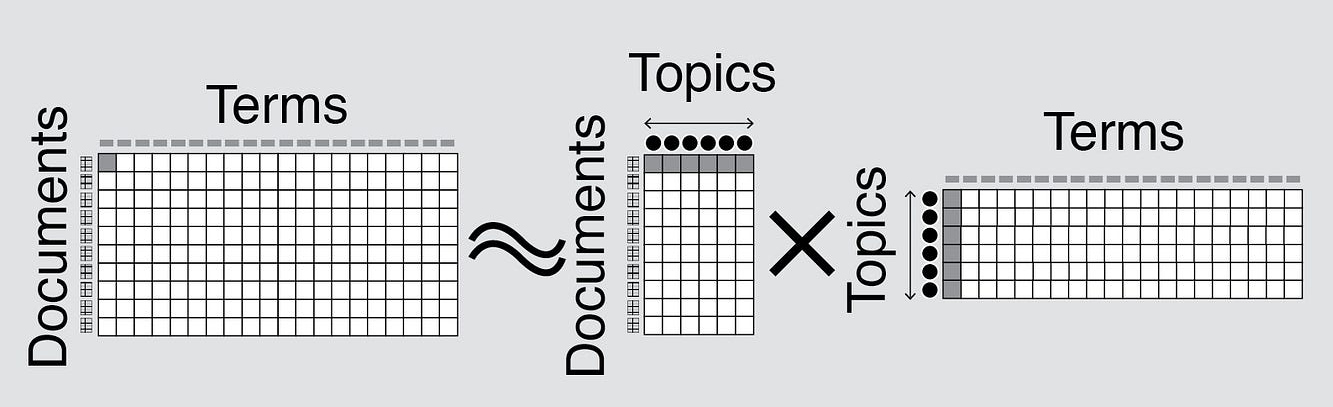

In [ ]:
from gensim.models import Nmf 

nmf_topic_model = Nmf(
    corpus = doc_term_matrix,     
    id2word = dictionary,   
    num_topics = 7,     
    random_state = 100,
    passes = 20,      
    )

In [ ]:
for topic_num, words in nmf_topic_model.show_topics():
    print('Representative words of topic {}: {}.'.format(topic_num, words))

In [ ]:
coherencemodel = CoherenceModel(model=nmf_topic_model, texts=clean_docs, dictionary=dictionary, coherence='c_v')
coherencemodel.get_coherence()

### BERTopic

BERTopic is a composition of multiple modular steps. The model starts by extracting embeddings for the documents, by default it uses [sentence transformers](https://www.sbert.net/) but it's possible to use any embedding model from gensim, HuggingFace, etc. Clustering models struggle with high dimentional data, that's why Dimentionality Reduction is applied before clustering the embeddings. What we are hoping for in this case is that similar documents will find themselves in the same cluster, and then we can find the most important words of each cluster using a tokenizer and c-TF-IDF. c-TF-IDF is a modification of TF-IDF that considers all the documents of each cluster as a single document, then tries to find the representative words of the cluster/topic.

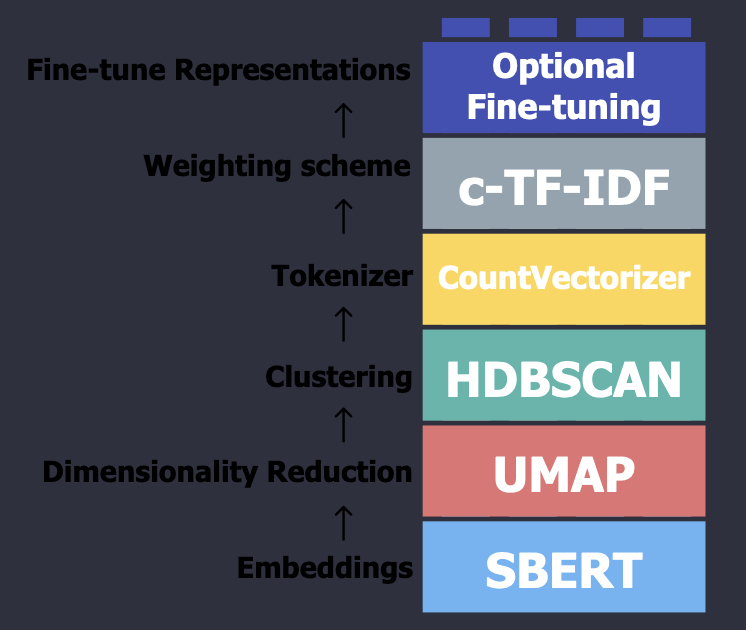

Below we instantiate and fit the model.

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)

### Exercice 4:
The topics and their top 10 representative words. You can see there are some stop words in there. Pass the list of English stopwords to BERTopic in order to clean the representations.

In [ ]:
topic_model.get_topics()

### Exercice 5:
Reduce the number of topics.

In [ ]:
### WRITE YOUR CODE HERE

In [ ]:
topic_model.get_topics()

`get_topic_info` shows the topic ID, the number of documents it contains, and the name of the topic which is generated based on the ID and the representative words.

### Exercice 6: 
Below we can see there is a topic with ID -1. Describe what it is useful for.

WRITE YOUR ANSWER HERE

In [ ]:
topic_model.get_topic_info()

This visualization applies UMAP to show a 2D visualization of topics and their distance. The size of the bubble reflects the number of documents in the topic. Similar documents should be close to each other.

In [ ]:
topic_model.visualize_topics()

Visualization of the documents in 2D where we can check whether documents are assigned correctly.

In [ ]:
topic_model.visualize_documents(docs, hide_annotations=True)

Hierchically reducing the number of topics based on their similarity. It shows how different clusters relate to each other, and can be used to find the number of topics or to find similar topics and merge them.

In [ ]:
topic_model.visualize_hierarchy()

### Exercice 7: 
In BERTopic, It's possible to merge topics if you perceive them as similar depending on your interpretation. Merging topics updates the topic representation which in turn updates the whole model.

Write code to merge topics that you think are similar then visualize the topics.

In [ ]:
# WRITE YOUR CODE HERE

### Exercice 8: 


The default clustering model that BERTopic uses is HDBSCAN. Change that to use KMeans instead, then re-run the code for getting topic representations and visualizations. Describe the key differences between using the two algorithms.

WRITE YOUR CODE AND ANSWER BELOW